### Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras import layers
from keras.models import Sequential

from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error



### Load dataset

In [2]:
!kaggle datasets download -d fekihmea/metro-interstate-traffic-volume

Dataset URL: https://www.kaggle.com/datasets/fekihmea/metro-interstate-traffic-volume
License(s): MIT
  0% 0.00/416k [00:00<?, ?B/s]
100% 416k/416k [00:00<00:00, 26.5MB/s]


In [3]:
!unzip /content/metro-interstate-traffic-volume.zip -d /content/

Archive:  /content/metro-interstate-traffic-volume.zip
  inflating: /content/Metro_Interstate_Traffic_Volume.csv  


In [4]:
df = pd.read_csv("/content/Metro_Interstate_Traffic_Volume.csv")


In [5]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### Data preprocessing

#### Convert `Timestamp` type to datetime

In [6]:
# Change the "date_time" type to date type
df["date_time"] = pd.to_datetime(df["date_time"])

# Ensuring values are sorted based on "date_time"
df.sort_values(by=["date_time"], inplace=True, ascending=True)

In [7]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


#### Check nan values

In [8]:
df.isnull().sum()

,0
holiday,48143
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0
traffic_volume,0


#### Drop **holiday** column

In [9]:
df = df.drop(columns=["holiday"])

#### Check and drop duplicates

In [10]:
df.duplicated().sum()

17

In [14]:
df = df.drop_duplicates()

In [15]:
df.duplicated().sum()

0

Text(0, 0.5, 'traffic_volume')

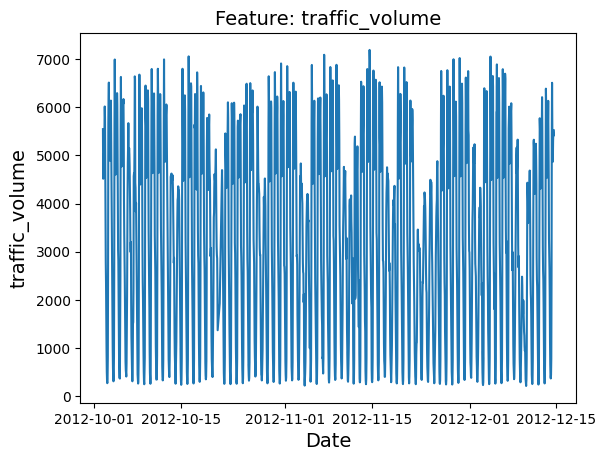

In [17]:
plot = sns.lineplot(x=df["date_time"][:2000], y=df["traffic_volume"][:2000])
plot.set_title('Feature: traffic_volume', fontsize=14)
plot.set_xlabel(xlabel="Date", fontsize=14)
plot.set_ylabel(ylabel="traffic_volume", fontsize=14)


#### Resampling visualization

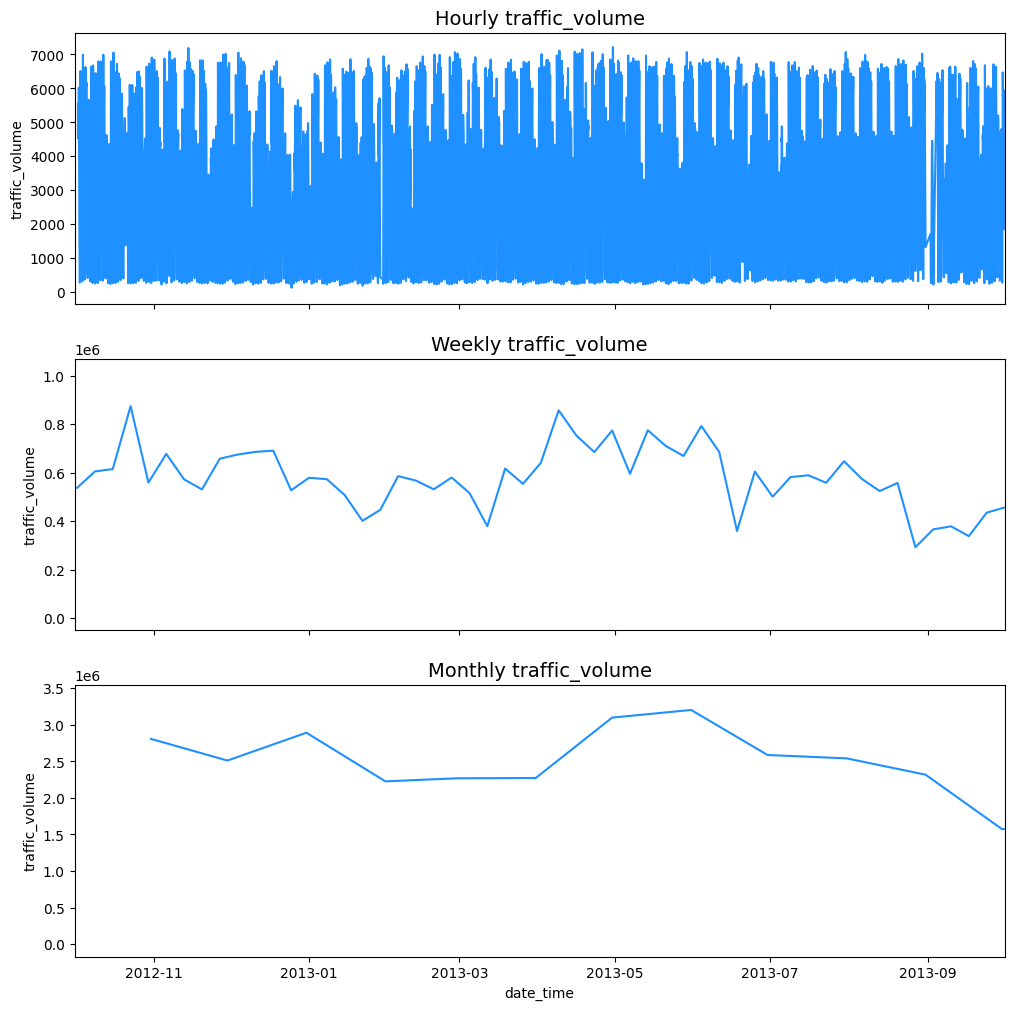

In [23]:
from datetime import date
nrows = 3
fig, ax = plt.subplots(nrows=nrows, sharex=True, figsize=(12,12))

df_to_show = df[["date_time", "traffic_volume"]][:]

sns.lineplot(x=df_to_show['date_time'], y=df_to_show['traffic_volume'], color='dodgerblue', ax=ax[0])
ax[0].set_title('Hourly traffic_volume', fontsize=14)

resampled_df = df_to_show[['date_time','traffic_volume']].resample('7D', on='date_time').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date_time'], y=resampled_df['traffic_volume'], color='dodgerblue', ax=ax[1])
ax[1].set_title('Weekly traffic_volume', fontsize=14)

resampled_df = df_to_show[['date_time','traffic_volume']].resample('M', on='date_time').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date_time'], y=resampled_df['traffic_volume'], color='dodgerblue', ax=ax[2])
ax[2].set_title('Monthly traffic_volume', fontsize=14)

for i in range(nrows):
    ax[i].set_xlim([date(2012, 10, 1), date(2013, 10, 1)])

plt.show()

### Train-Test split

In [24]:
new_df = df[["traffic_volume"]]

train_size = int(len(df) * 0.8)
train_data = new_df.iloc[:train_size]
test_data = new_df.iloc[train_size:]

### Feature Scaling


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [26]:
def create_dataset(dataset, steps):
    X, Y = [], []
    for i in range(len(dataset) - steps - 1):
        a = dataset[i:(i + steps), 0:dataset.shape[1]]
        X.append(a)
        Y.append(dataset[i + steps, 0])
    return np.array(X), np.array(Y)

steps = 20
X_train, y_train = create_dataset(train_data_scaled, steps)
X_test, y_test = create_dataset(test_data_scaled, steps)

In [27]:
print("X_train.shape")
print(X_train.shape)
print("X_test.shape")
print(X_test.shape)

X_train.shape
(38528, 20, 1)
X_test.shape
(9617, 20, 1)


### Model 1 Training (RNN)

In [28]:
model_rnn = Sequential()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model_rnn.add(layers.SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_rnn.add(layers.Dropout(0.2))

model_rnn.add(layers.SimpleRNN(units=50, return_sequences=True))

model_rnn.add(layers.SimpleRNN(units=50, return_sequences=False))
model_rnn.add(layers.Dropout(0.2))
model_rnn.add(layers.BatchNormalization())

model_rnn.add(layers.Dense(units=1))
model_rnn.summary()

keras.utils.plot_model(model_rnn, "rnn.png", show_shapes=True)

model_rnn.compile(optimizer="adam", loss="mean_squared_error")


history_rnn = model_rnn.fit(X_train, y_train,
               epochs=50,
               callbacks=[early_stopping],
               validation_split=0.2,
               batch_size=32
               )


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 20, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 20, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,951 (50.59 KB)

 Trainable params: 12,851 (50.20 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.3472 - val_loss: 0.0173
Epoch 2/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0244 - val_loss: 0.0069
Epoch 3/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.0141 - val_loss: 0.0060
Epoch 4/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0131 - val_loss: 0.0056
Epoch 5/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0120 - val_loss: 0.0052
Epoch 6/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0114 - val_loss: 0.0049
Epoch 7/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0109 - val_loss: 0.0048
Epoch 8/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0104 - val_loss: 0.0067
Epoch 9/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.0103 - val_loss: 0.0068
Epoch 10/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0101 - val_loss: 0.0042
Epoch 11/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.0098 - val_loss: 0.0053
Epoch 12/50
964/964 ━━━━━━━━━━

#### Test Prediction

In [29]:
rnn_y = model_rnn.predict(X_test)


301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


#### Evaluation

In [30]:
# Calculating MAE and RMSE
mae_rnn = mean_absolute_error(y_test, rnn_y)
rmse_rnn = mean_squared_error(y_test, rnn_y, squared=False)

print("Mean Absolute Error: ", mae_rnn)
print("Root Mean Square Error: ", rmse_rnn)

Mean Absolute Error:  0.03814194442666769
Root Mean Square Error:  0.05520401642666586


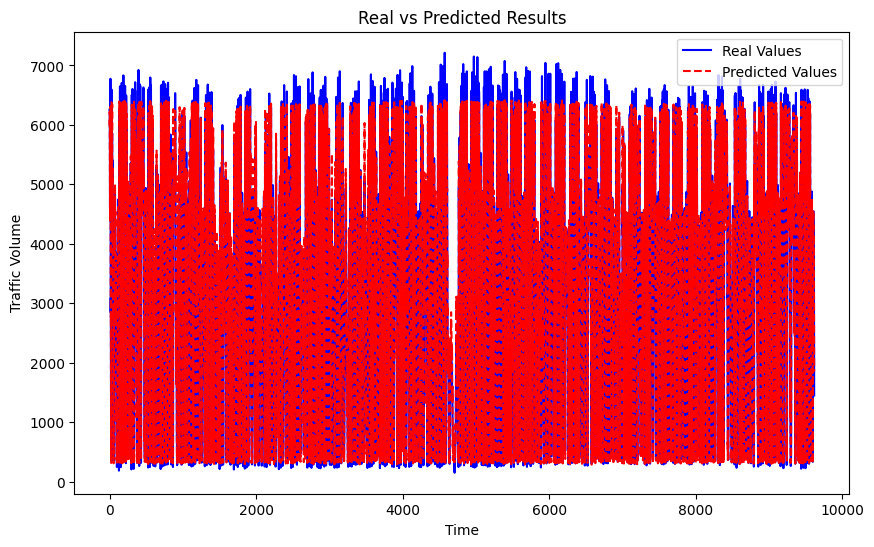

In [31]:
plt.figure(figsize=(10, 6))

plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Real Values')

plt.plot(scaler.inverse_transform(rnn_y), color='red', linestyle='--', label='Predicted Values')

plt.title('Real vs Predicted Results')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')

plt.legend()

plt.show()

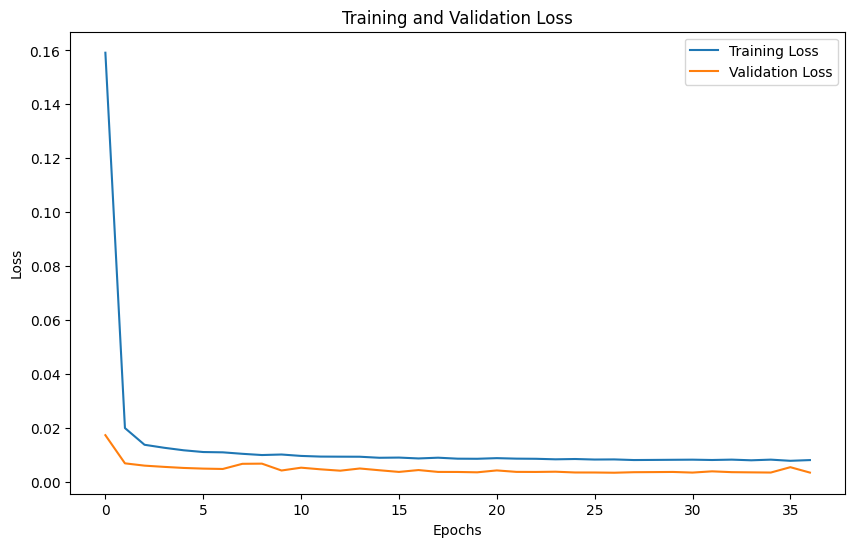

In [32]:

loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']

plt.figure(figsize=(10, 6))

plt.plot(loss, label='Training Loss')

plt.plot(val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

### Model 2 Training (LSTM)

In [34]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model_lstm = Sequential()

model_lstm.add(layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(layers.Dropout(0.2))
model_lstm.add(layers.LSTM(units=50, return_sequences=True))
model_lstm.add(layers.LSTM(units=50, return_sequences=False))
model_lstm.add(layers.Dropout(0.2))
model_lstm.add(layers.BatchNormalization())


model_lstm.add(layers.Dense(1))

model_lstm.compile(optimizer="adam", loss="mean_squared_error")

keras.utils.plot_model(model_lstm, "lstm.png", show_shapes=True)


history_lstm = model_lstm.fit(X_train, y_train,
               epochs=50,
               callbacks=[early_stopping],
               validation_split=0.2,
               batch_size=32
               )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - loss: 0.0674 - val_loss: 0.0097
Epoch 2/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 72s 33ms/step - loss: 0.0149 - val_loss: 0.0079
Epoch 3/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - loss: 0.0131 - val_loss: 0.0100
Epoch 4/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0127 - val_loss: 0.0072
Epoch 5/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 0.0122 - val_loss: 0.0059
Epoch 6/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - loss: 0.0118 - val_loss: 0.0072
Epoch 7/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - loss: 0.0114 - val_loss: 0.0065
Epoch 8/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - loss: 0.0112 - val_loss: 0.0071
Epoch 9/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0112 - val_loss: 0.0050
Epoch 10/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - loss: 0.0100 - val_loss: 0.0054
Epoch 11/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - loss: 0.0096 - val_loss: 0.0048
Epoch 12/50
964/964 ━━━━━━━━━━

### Test prediction

In [35]:
lstm_y = model_lstm.predict(X_test)


301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


### Evaluation

In [36]:
# Calculating MAE and RMSE
mae_lstm = mean_absolute_error(y_test, lstm_y)
rmse_lstm = mean_squared_error(y_test, lstm_y, squared=False)

print("Mean Absolute Error: ", mae_lstm)
print("Root Mean Square Error: ", rmse_lstm)


Mean Absolute Error:  0.03770724815871189
Root Mean Square Error:  0.05443193054403154


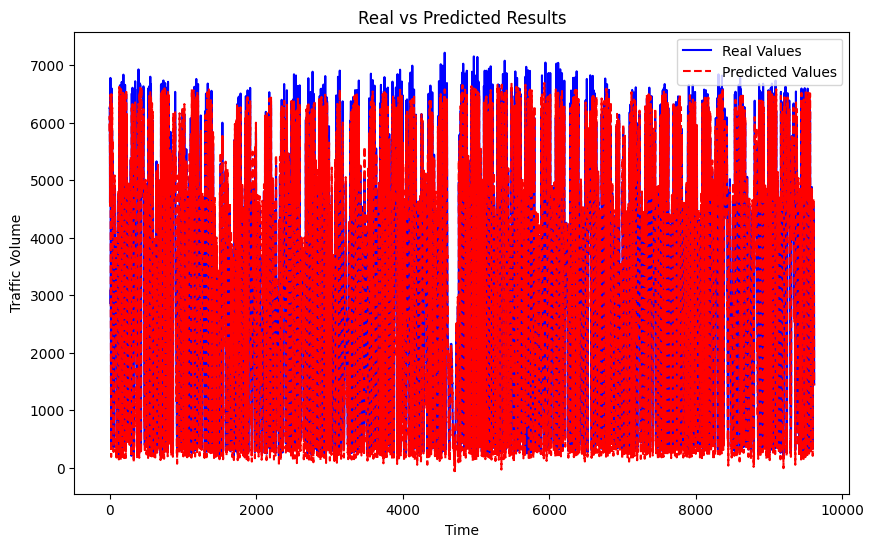

In [37]:
plt.figure(figsize=(10, 6))

plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Real Values')

plt.plot(scaler.inverse_transform(lstm_y), color='red', linestyle='--', label='Predicted Values')

plt.title('Real vs Predicted Results')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')

plt.legend()

plt.show()


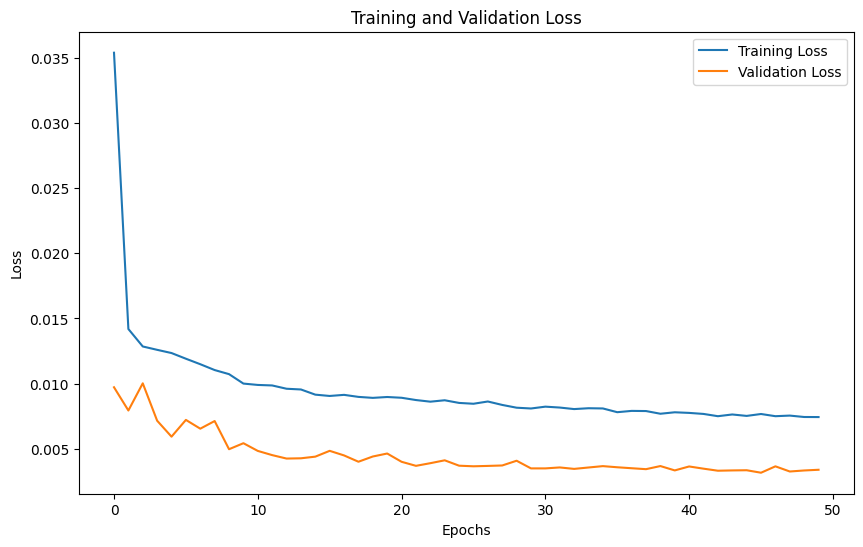

In [38]:
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

plt.figure(figsize=(10, 6))

plt.plot(loss, label='Training Loss')

plt.plot(val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

### Model 3 Training (GRU)

In [40]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

gru_model = Sequential()

gru_model.add(layers.GRU(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(layers.Dropout(0.2))
gru_model.add(layers.GRU(units=20, return_sequences=True))
gru_model.add(layers.Dropout(0.2))
gru_model.add(layers.GRU(units=20, return_sequences=False))
gru_model.add(layers.Dropout(0.2))


gru_model.add(layers.Dense(1))

gru_model.compile(optimizer="adam", loss="mean_squared_error")

keras.utils.plot_model(gru_model, "gru.png", show_shapes=True)


history_gru = gru_model.fit(X_train, y_train,
               epochs=30,
               callbacks=[early_stopping],
               validation_split=0.2,
               batch_size=32
               )

Epoch 1/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0500 - val_loss: 0.0076
Epoch 2/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 0.0134 - val_loss: 0.0064
Epoch 3/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - loss: 0.0118 - val_loss: 0.0061
Epoch 4/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - loss: 0.0111 - val_loss: 0.0061
Epoch 5/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - loss: 0.0106 - val_loss: 0.0055
Epoch 6/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 7/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - loss: 0.0095 - val_loss: 0.0053
Epoch 8/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0089 - val_loss: 0.0047
Epoch 9/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0089 - val_loss: 0.0046
Epoch 10/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - loss: 0.0084 - val_loss: 0.0048
Epoch 11/30
964/964 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0084 - val_loss: 0.0049
Epoch 12/30
964/964 ━━━━━━━━━━

#### Test Prediction

In [41]:
gru_y = gru_model.predict(X_test)


301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


#### Evaluation

In [42]:

# Calculating MAE and RMSE
mae_gru = mean_absolute_error(y_test, gru_y)
rmse_gru = mean_squared_error(y_test, gru_y, squared=False)

print("Mean Absolute Error: ", mae_gru)
print("Root Mean Square Error: ", rmse_gru)


Mean Absolute Error:  0.03944806916625525
Root Mean Square Error:  0.057076267239149846


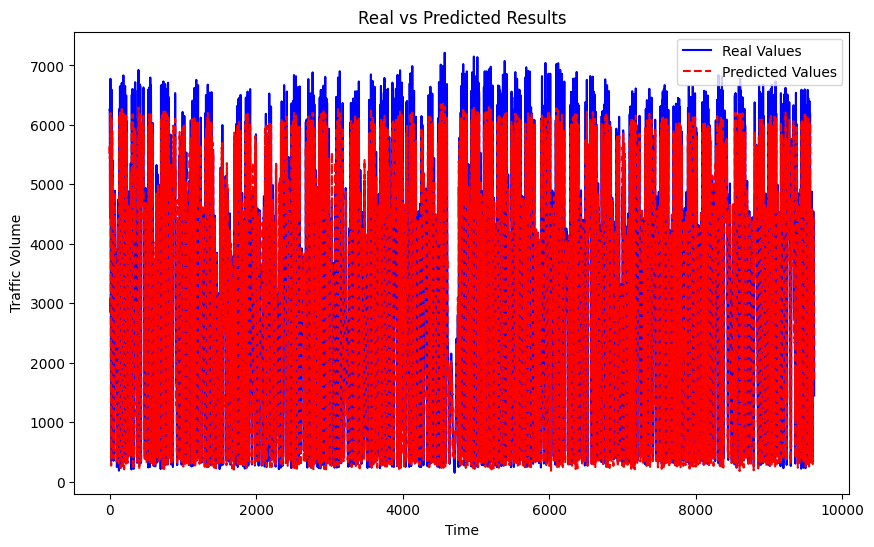

In [43]:

plt.figure(figsize=(10, 6))

plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Real Values')

plt.plot(scaler.inverse_transform(gru_y), color='red', linestyle='--', label='Predicted Values')

plt.title('Real vs Predicted Results')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')

plt.legend()

plt.show()


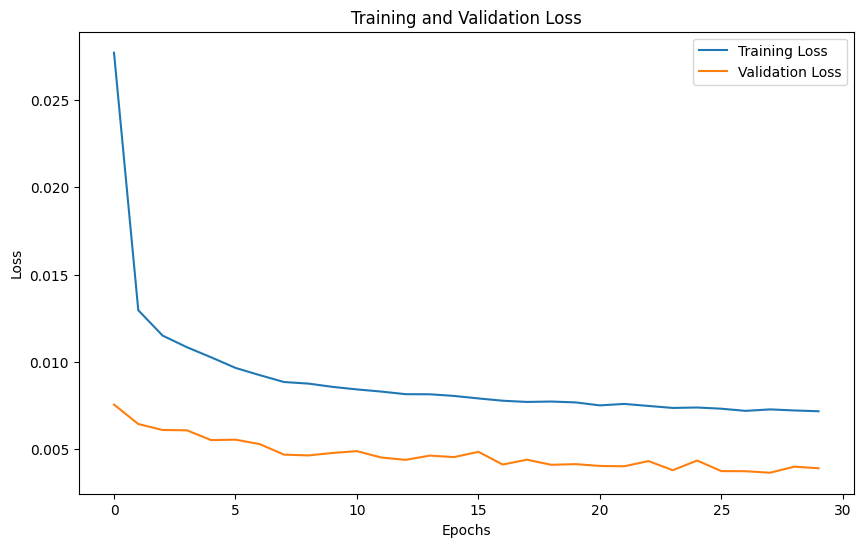

In [44]:

loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']

plt.figure(figsize=(10, 6))

plt.plot(loss, label='Training Loss')

plt.plot(val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()